In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

[-2.81715557e-02  9.41759555e-05  1.40221006e-02 ...  3.17568461e-03
 -1.32421274e-02 -1.32634272e-02]


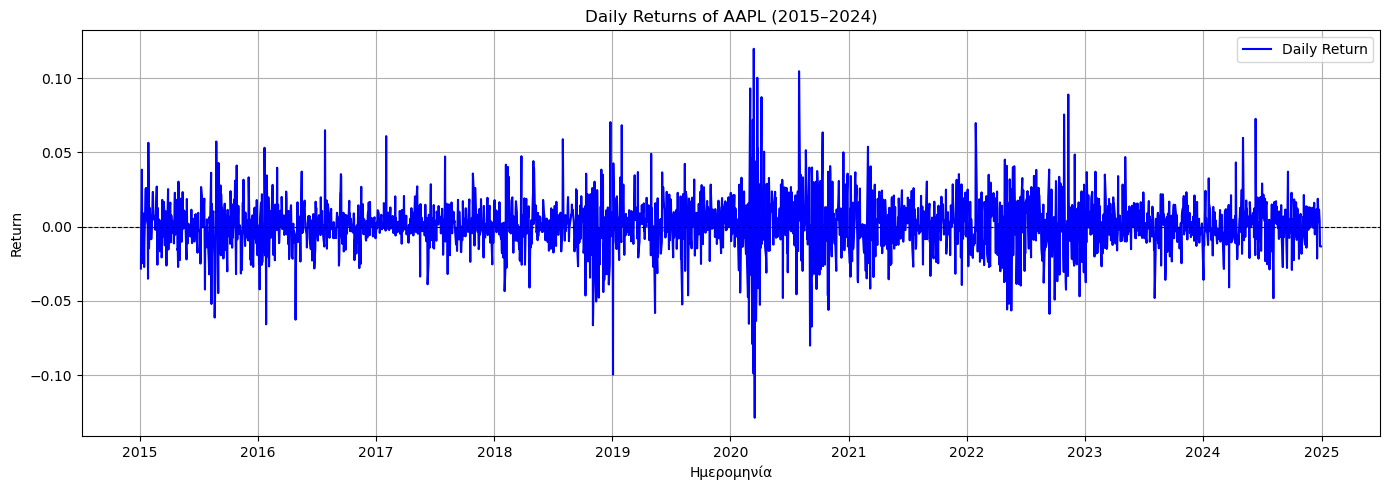

In [2]:

# Φέρνουμε τα δεδομένα
aapl = yf.Ticker("AAPL")
df = aapl.history(start="2015-01-01", end="2024-12-31")

# Υπολογίζουμε τα daily returns
df['Return'] = df['Close'].pct_change()

# Φιλτράρουμε τα NaN (πρώτη γραμμή)
returns = df['Return'].dropna().values

# Αποθήκευση ως NumPy αρχείο
np.save("aapl_daily_returns.npy", returns)

print(returns)
print(

plt.figure(figsize=(14, 5))
plt.plot(df.index, df['Return'], label='Daily Return', color='blue')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title("Daily Returns of AAPL (2015–2024)") 
plt.xlabel("Ημερομηνία")
plt.ylabel("Return")
plt.grid(True) 
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Return
Date,,,,,,,,
2015-01-02 00:00:00-05:00,24.778679,24.789802,23.879981,24.320433,212818400,0.0,0.0,NaN
2015-01-05 00:00:00-05:00,24.089086,24.169168,23.448431,23.635288,257142000,0.0,0.0,-0.028172
2015-01-06 00:00:00-05:00,23.699800,23.897780,23.274920,23.637514,263188400,0.0,0.0,0.000094
2015-01-07 00:00:00-05:00,23.846614,24.069063,23.735389,23.968962,160423600,0.0,0.0,0.014022
2015-01-08 00:00:00-05:00,24.298183,24.947736,24.180283,24.889898,237458000,0.0,0.0,0.038422
...,...,...,...,...,...,...,...,...
2024-12-23 00:00:00-05:00,254.490204,255.369227,253.171646,254.989655,40858800,0.0,0.0,0.003065
2024-12-24 00:00:00-05:00,255.209412,257.926411,255.009620,257.916443,23234700,0.0,0.0,0.011478
2024-12-26 00:00:00-05:00,257.906429,259.814335,257.347047,258.735504,27237100,0.0,0.0,0.003176


In [36]:
def windowing(returns, win_predictor, win_target):
    X, y = [], []
    for i in range(len(returns) - win_predictor - win_target + 1):
        X.append(returns[i : i + win_predictor])
        y.append(returns[i + win_predictor : i + win_predictor + win_target])
    
    return np.array(X), np.array(y)

'''X_train, y_train = windowing(series_train, win_predictor=5, win_target=1)
X_test,  y_test  = windowing(series_test,  win_predictor=5, win_target=1)
print('X_train: %-9s | y_train: %s' % (X_train.shape, y_train.shape))
print('X_test:  %-9s | y_test:  %s' % (X_test.shape,  y_test.shape))'''

"X_train, y_train = windowing(series_train, win_predictor=5, win_target=1)\nX_test,  y_test  = windowing(series_test,  win_predictor=5, win_target=1)\nprint('X_train: %-9s | y_train: %s' % (X_train.shape, y_train.shape))\nprint('X_test:  %-9s | y_test:  %s' % (X_test.shape,  y_test.shape))"

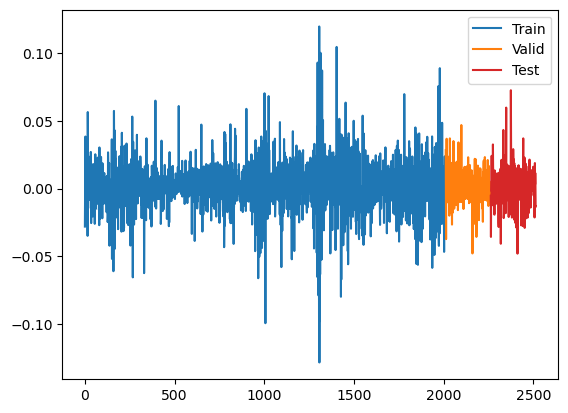

In [37]:
# 1. Train/Valid/Test split
from sklearn.model_selection import train_test_split

series = returns 

series_train, series_test, _, _ = train_test_split(series, series, test_size=0.2, shuffle=False, random_state=42)
##prosthesa ayto edw panw 
train_size = int(0.8 * len(series))   # 80% for training
valid_size = int(0.1 * len(series))   # 10% for validation
test_size  = len(series) - train_size - valid_size  # Remaining 10% for testing

series_train, series_valid, series_test = (
    series[:train_size],                          # Training set
    series[train_size:train_size + valid_size],   # Validation set
    series[train_size + valid_size:]              # Test set
)

timesteps_train = np.arange(len(series_train))
timesteps_valid = np.arange(len(series_valid)) + len(series_train)
timesteps_test  = np.arange(len(series_test))  + len(series_train) + len(series_valid)

plt.plot(timesteps_train, series_train, c='C0', label='Train')
plt.plot(timesteps_valid, series_valid, c='C1', label='Valid')
plt.plot(timesteps_test,  series_test,  c='C3', label='Test')
plt.legend()
plt.show() #στον χ αξονα βλεπω τον index του δειγματος ! 2515 δειγματα συνολικα 

In [38]:
# 3. Windowing (you will soon see why we call them "_2D")
X_train_2D, y_train_2D = windowing(series_train, win_predictor=5, win_target=1)
X_valid_2D, y_valid_2D = windowing(series_valid, win_predictor=5, win_target=1)
X_test_2D,  y_test_2D  = windowing(series_test,  win_predictor=5, win_target=1)

# 4. Print shapes
print('X_train: %-9s | y_train: %s' % (X_train_2D.shape, y_train_2D.shape))
print('X_valid: %-9s | y_valid: %s' % (X_valid_2D.shape, y_valid_2D.shape))
print('X_test:  %-9s | y_test:  %s' % (X_test_2D.shape,  y_test_2D.shape))

X_train: (2006, 5) | y_train: (2006, 1)
X_valid: (246, 5)  | y_valid: (246, 1)
X_test:  (247, 5)  | y_test:  (247, 1)


In [42]:
#κανονικοποιηση
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_n = scaler.fit_transform(X_train_2D)
X_valid_n = scaler.fit_transform(X_valid_2D)
X_test_n  = scaler.transform(X_test_2D)

#reshaping the data in order for RNN to work. 
X_train = X_train_n[:, :, np.newaxis]
X_valid = X_valid_n[:, :, np.newaxis]
X_test  = X_test_n[:, :, np.newaxis]


In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RNN, SimpleRNNCell, Dense
from tensorflow.keras.utils import plot_model
# Set seeds for reproducibility
tf.random.set_seed(42)

In [43]:
# Number of hidden units (neurons)
hidden_dim = 32

# Define model using an RNN cell inside an RNN layer
model = Sequential(name="Shallow_RNN")
model.add(RNN(SimpleRNNCell(hidden_dim), input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dense(1))  # Output layer
model.compile(optimizer='adam', loss='mse')
model.summary()

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid_2D), epochs=50, batch_size=32, verbose=1);

C:\Users\souli\New_folder\envs\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "Shallow_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rnn_5 (RNN)                          │ (None, 32)                  │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,121 (4.38 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0867 - val_loss: 0.0023
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025 - val_loss: 0.0010
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 - val_loss: 6.0583e-04
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010 - val_loss: 4.4721e-04
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.9853e-04 - val_loss: 3.7490e-04
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.7419e-04 - val_loss: 3.4287e-04
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.0166e-04 - val_loss: 3.3107e-04
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.5887e-04 - val_loss: 3.2778e-04
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.3380e-04 - val_loss: 3.2628e-04
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.1884e-04 - val_loss: 3.2318e-04
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.0921e-04 - val_loss: 3.1799e-04
Epoch 12/5

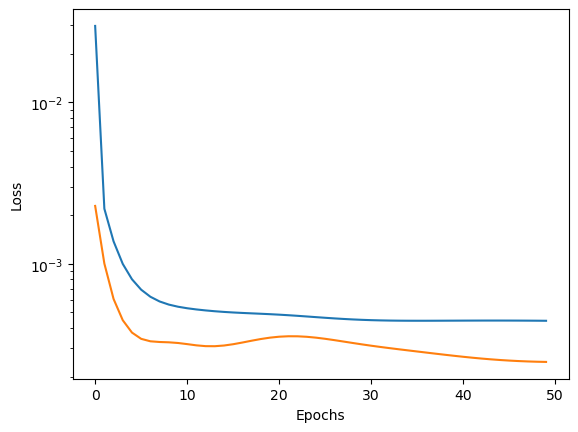

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step 
Mean Squared Error (test): 0.00


In [44]:
from sklearn.metrics import mean_squared_error

plt.plot(history.epoch, history.history['loss'], label='Training Loss')
plt.plot(history.epoch, history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.yscale('log')
plt.show()

yhat_test = model.predict(X_test)

# Evaluate the model
MSE_test = mean_squared_error(y_test, yhat_test)
print("Mean Squared Error (test): %.2f" % MSE_test)

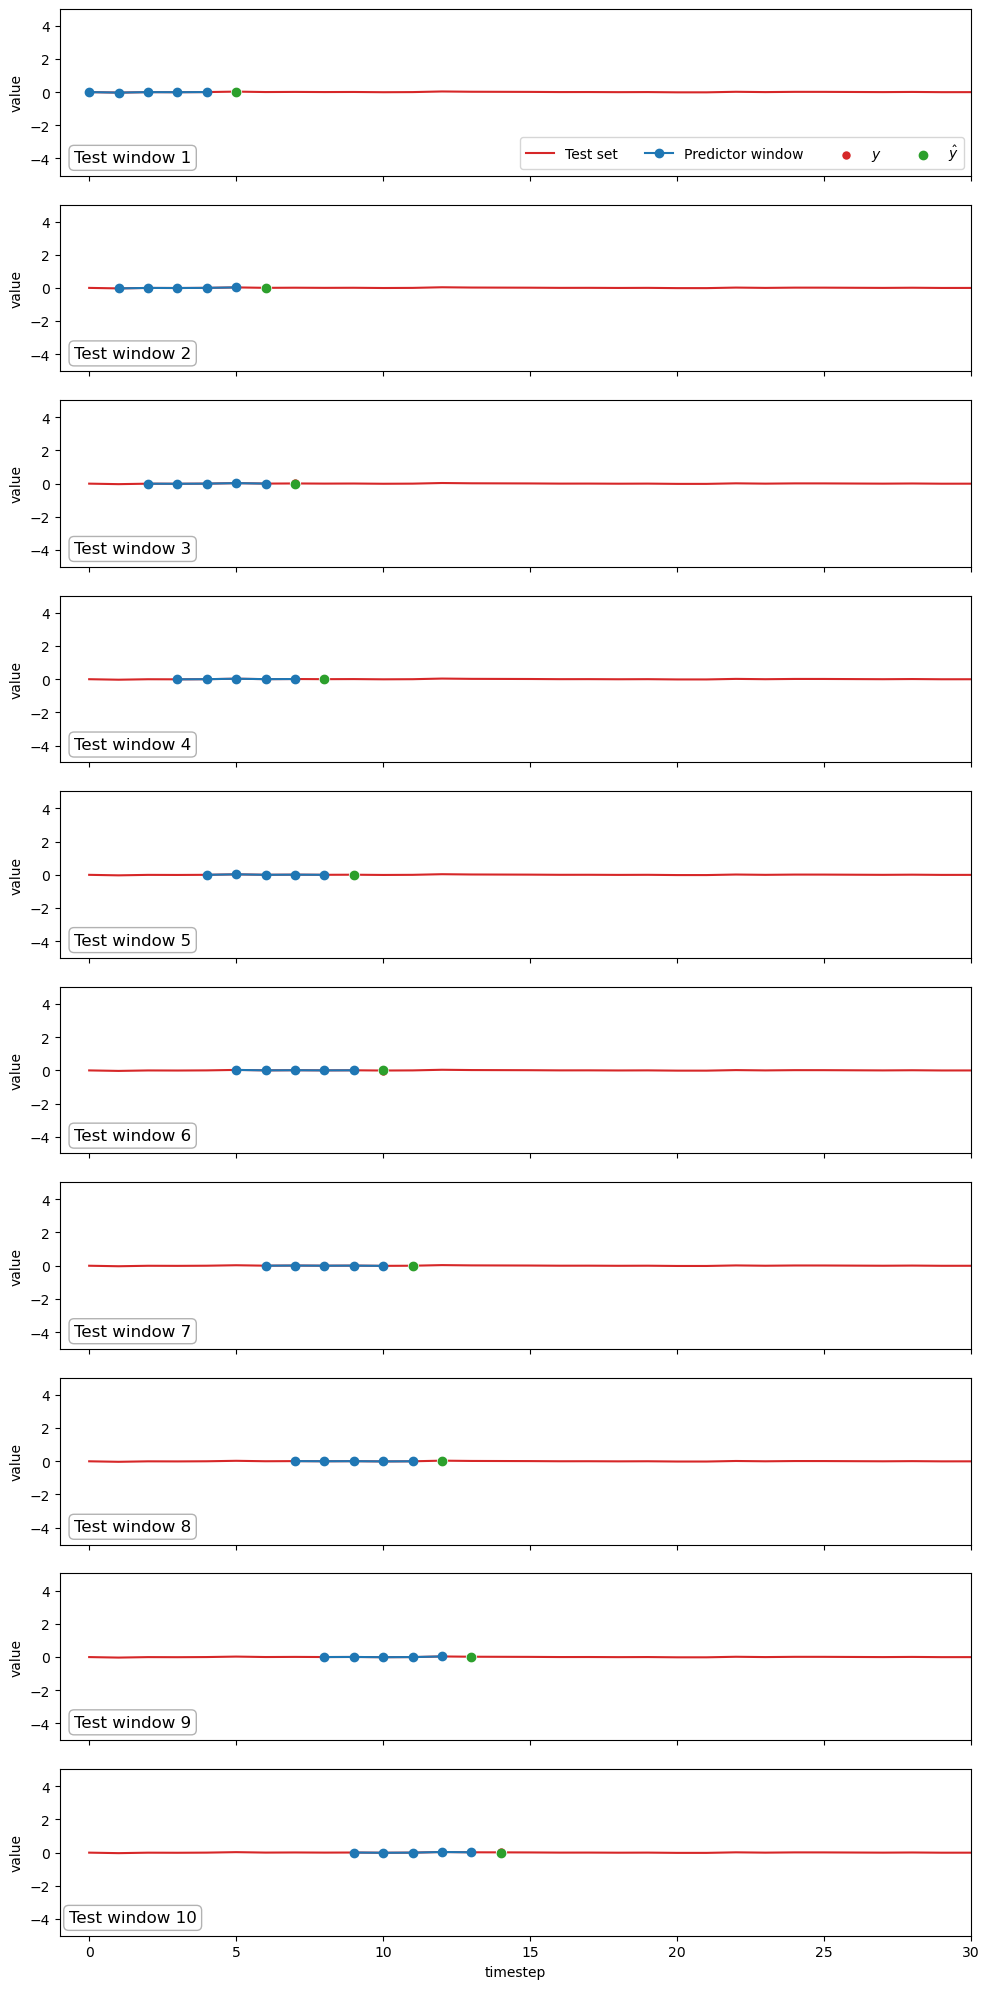

In [45]:
import matplotlib.pyplot as plt
import numpy as np

def plot_windows_predictions(series_test, X_test_2D, y_test, yhat_test, n_windows=5):
    """
    Plots input windows with corresponding target and prediction.
    
    Parameters:
    X_test_2D : np.array
        The input sequences (test set) of shape (num_samples, window_size,).
    y_test : np.array
        The true target values of shape (num_samples,).
    yhat_test : np.array
        The predicted target values of shape (num_samples,).
    n_windows : int, optional
        Number of windows to plot (default is 5).
    """
    n_windows = min(n_windows, len(X_test_2D))
    
    fig, axes = plt.subplots(n_windows, 1, figsize=(10, n_windows * 2), sharex=True)
    
    for i, ax in enumerate(axes):
        ax.plot(series_test, label='Test set', c='C3', zorder=-1)
        ax.plot(np.arange(i, i+len(X_test_2D[i])), X_test_2D[i, :], label='Predictor window', marker='o', c='C0')
        ax.scatter(i+len(X_test_2D[i]), y_test[i], color='C3', edgecolors='white', linewidth=1, s=50, label='$y$')
        ax.scatter(i+len(X_test_2D[i]), yhat_test[i], color='C2', label='$\hat{y}$')
        
        ax.text(0.08, 0.08, f"Test window {i+1}", fontsize=12, ha='center', transform=ax.transAxes,
                 bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.3))
        ax.set_ylabel("value")
        ax.set_xlim(-1, 30)
        ax.set_ylim(np.min(X_test_2D[i])-5, np.max(X_test_2D[i])+5)
        
        if i == 0:
            ax.legend(loc="lower right", ncols=4)
    
    axes[-1].set_xlabel("timestep")
    plt.tight_layout()
    plt.show()

plot_windows_predictions(series_test, X_test_2D, y_test, yhat_test, n_windows=10)